In [2]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好.
# 在Windows需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## 一、加载数据
1. 首先，我们需要学习PyTorch自带的数据加载器，包括dataset，sampler，以及data loader这三个对象组成的套件。
2. 当数据集很小，格式比较规则的时候，数据加载三套件的优势并不明显。但是当数据格式比较特殊，以及数据规模很大（内存无法同时加载所有数据）
的时候，特别是，我们需要用不同的处理器来加载数据的时候，三套件的威力就会显现出来了。它会将数据加载、分布的任务自动完成。
3. 在使用的时候，我们用dataset来装载数据集，用sampler来采样数据集。而对数据集的迭代、循环则主要通过data_loader来完成。
4. 创建一个data_loader就需要一个dataset和一个datasampler，它基本实现的就是利用sampler自动从dataset种采样

In [3]:
# 定义超参数
image_size = 28
num_classes = 10
num_epochs = 20
batch_size = 64

train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data',
                          train=False,
                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据。
校验数据用于检测模型是否过拟合，并调整参数，测试数据检验整个模型的工作'''
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          sampler=sampler_test)

训练集详情： Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Img_size: (1, 28, 28)
标签是： 0


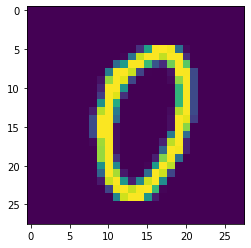

In [4]:
#随便从数据集中读入一张图片，并绘制出来
idx = 1000

#dataset支持下标索引，其中提取出来的每一个元素为features，target格式，即属性和标签。[0]表示索引features
muteimg = train_dataset[idx][0].numpy()
#由于一般的图像包含rgb三个通道，而MINST数据集的图像都是灰度的，只有一个通道。因此，我们忽略通道，把图像看作一个灰度矩阵。
#用imshow画图，会将灰度矩阵自动展现为彩色，不同灰度对应不同颜色：从黄到紫

plt.imshow(muteimg[0,...])
print('训练集详情：',train_dataset)
print('Img_size:',muteimg.shape)
print('标签是：',train_dataset[idx][1])

## 二、基本的卷积神经网络
### 2.1 构建网络
1. 首先，我们构造ConvNet类，它是对类nn.Module的继承（即nn.Module是父类，ConvNet为子类。如果这些概念不熟悉，请参考面向对象编程）
2. 然后，我们复写__init__，以及forward这两个函数。第一个为构造函数，每当类ConvNet被具体化一个实例的时候，就会调用，forward则是
在运行神经网络正向的时候会被自动调用
3. 自定义自己的方法

另一需要理解的是，ConvNet其实也是一个大容器，它里面有Conv2d，MaxPool2d等组件

In [5]:
#定义卷积神经网络：4和8为人为指定的两个卷积层的厚度（feature map的数量）
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        # 首先调用父类相应的构造函数
        super(ConvNet, self).__init__()
        
        # 其次构造ConvNet需要用到的各个神经模块。
        self.conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        #该函数完成神经网络真正的前向运算，我们会在这里把各个组件进行实际的拼装
        #x的尺寸：(batch_size, image_channels, image_width, image_height)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=0)
        return x
    
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)

### 2.2 训练这个卷积神经网络

In [6]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] #按行取最大值 [1]是index [0]是值
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)#返回正确的数量和这一次一共比较了多少元素

In [7]:
net = ConvNet() #新建一个卷积神经网络的实例，此时ConvNet的__init__函数就会被自动调用

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

record = [] #记录准确率等数值的容器
weights = [] #每若干步就记录一次卷积核

#开始训练循环
for epoch in range(num_epochs):
    train_rights = []#记录训练数据集准确率的容器
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.clone().requires_grad_(True), target.clone().detach()
        net.train() # 给网络模型做标记，标志说模型正在训练集上训练，
                    #这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout
        
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = rightness(output, target)
        train_rights.append(right)
        
        if batch_idx % 100 == 0: #每100个batch执行一次打印操作
            net.eval()
            val_rights = []
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data)
                right = rightness(output, target)
                val_rights.append(right)
                
            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print(val_r)
            print('训练周期：{}[{}/{} ({:.0f}%)]\tLoss：{:.6f}\t训练正确率：{:.2f}%\t校验正确率：{:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0] / train_r[1],
                100. * val_r[0] / val_r[1]))
            
            #将准确率和权重等数值加载到容器中，以方便后续处理
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. *  val_r[0] / val_r[1]))
            # weights记录了训练周期中所有卷积核的演化过程。
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])

(tensor(487), 5000)
训练周期：0[0/60000 (0%)]	Loss：2.298612	训练正确率：14.00%	校验正确率：9.00%
(tensor(1058), 5000)
训练周期：0[6400/60000 (11%)]	Loss：2.303717	训练正确率：11.00%	校验正确率：21.00%
(tensor(1984), 5000)
训练周期：0[12800/60000 (21%)]	Loss：2.296443	训练正确率：13.00%	校验正确率：39.00%
(tensor(2516), 5000)
训练周期：0[19200/60000 (32%)]	Loss：2.284404	训练正确率：15.00%	校验正确率：50.00%
(tensor(2760), 5000)
训练周期：0[25600/60000 (43%)]	Loss：2.259588	训练正确率：19.00%	校验正确率：55.00%
(tensor(2853), 5000)
训练周期：0[32000/60000 (53%)]	Loss：2.167889	训练正确率：23.00%	校验正确率：57.00%
(tensor(3360), 5000)
训练周期：0[38400/60000 (64%)]	Loss：1.674481	训练正确率：27.00%	校验正确率：67.00%
(tensor(3759), 5000)
训练周期：0[44800/60000 (75%)]	Loss：1.114595	训练正确率：32.00%	校验正确率：75.00%
(tensor(3980), 5000)
训练周期：0[51200/60000 (85%)]	Loss：0.823886	训练正确率：37.00%	校验正确率：79.00%
(tensor(4115), 5000)
训练周期：0[57600/60000 (96%)]	Loss：0.554128	训练正确率：42.00%	校验正确率：82.00%
(tensor(4131), 5000)
训练周期：1[0/60000 (0%)]	Loss：0.674172	训练正确率：76.00%	校验正确率：82.00%
(tensor(4202), 5000)
训练周期：1[6400/60000 (11%)]	Loss：0.509

(tensor(4853), 5000)
训练周期：9[32000/60000 (53%)]	Loss：0.091865	训练正确率：96.00%	校验正确率：97.00%
(tensor(4842), 5000)
训练周期：9[38400/60000 (64%)]	Loss：0.114647	训练正确率：96.00%	校验正确率：96.00%
(tensor(4841), 5000)
训练周期：9[44800/60000 (75%)]	Loss：0.052002	训练正确率：96.00%	校验正确率：96.00%
(tensor(4843), 5000)
训练周期：9[51200/60000 (85%)]	Loss：0.077453	训练正确率：96.00%	校验正确率：96.00%
(tensor(4859), 5000)
训练周期：9[57600/60000 (96%)]	Loss：0.176573	训练正确率：96.00%	校验正确率：97.00%
(tensor(4839), 5000)
训练周期：10[0/60000 (0%)]	Loss：0.164394	训练正确率：93.00%	校验正确率：96.00%
(tensor(4844), 5000)
训练周期：10[6400/60000 (11%)]	Loss：0.016773	训练正确率：96.00%	校验正确率：96.00%
(tensor(4855), 5000)
训练周期：10[12800/60000 (21%)]	Loss：0.055440	训练正确率：96.00%	校验正确率：97.00%
(tensor(4844), 5000)
训练周期：10[19200/60000 (32%)]	Loss：0.160287	训练正确率：96.00%	校验正确率：96.00%
(tensor(4843), 5000)
训练周期：10[25600/60000 (43%)]	Loss：0.111513	训练正确率：96.00%	校验正确率：96.00%
(tensor(4854), 5000)
训练周期：10[32000/60000 (53%)]	Loss：0.084248	训练正确率：96.00%	校验正确率：97.00%
(tensor(4850), 5000)
训练周期：10[38400/60000 (6

(tensor(4887), 5000)
训练周期：18[57600/60000 (96%)]	Loss：0.079732	训练正确率：97.00%	校验正确率：97.00%
(tensor(4887), 5000)
训练周期：19[0/60000 (0%)]	Loss：0.046076	训练正确率：98.00%	校验正确率：97.00%
(tensor(4894), 5000)
训练周期：19[6400/60000 (11%)]	Loss：0.033255	训练正确率：98.00%	校验正确率：97.00%
(tensor(4897), 5000)
训练周期：19[12800/60000 (21%)]	Loss：0.098154	训练正确率：98.00%	校验正确率：97.00%
(tensor(4889), 5000)
训练周期：19[19200/60000 (32%)]	Loss：0.066936	训练正确率：98.00%	校验正确率：97.00%
(tensor(4891), 5000)
训练周期：19[25600/60000 (43%)]	Loss：0.073761	训练正确率：97.00%	校验正确率：97.00%
(tensor(4891), 5000)
训练周期：19[32000/60000 (53%)]	Loss：0.034781	训练正确率：98.00%	校验正确率：97.00%
(tensor(4891), 5000)
训练周期：19[38400/60000 (64%)]	Loss：0.012161	训练正确率：97.00%	校验正确率：97.00%
(tensor(4872), 5000)
训练周期：19[44800/60000 (75%)]	Loss：0.056150	训练正确率：97.00%	校验正确率：97.00%
(tensor(4886), 5000)
训练周期：19[51200/60000 (85%)]	Loss：0.017608	训练正确率：98.00%	校验正确率：97.00%
(tensor(4881), 5000)
训练周期：19[57600/60000 (96%)]	Loss：0.226978	训练正确率：98.00%	校验正确率：97.00%


Text(0, 0.5, 'Error rate')

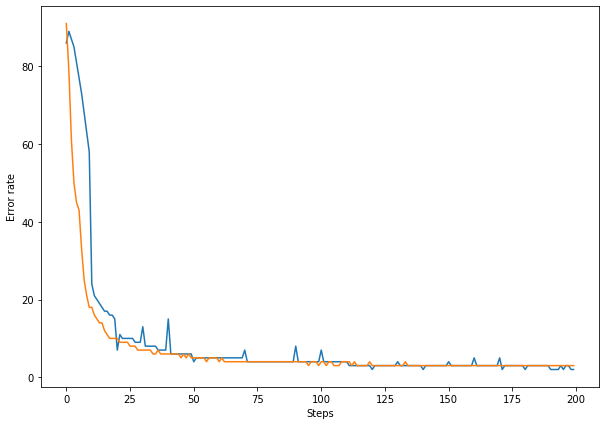

In [8]:
#绘制训练过程的误差曲线，训练集和校验集上的错误率。
plt.figure(figsize = (10, 7))
plt.plot(record)
plt.xlabel('Steps')
plt.ylabel('Error rate')

### 2.3 在测试集上进行分类

In [9]:
#在测试集上分批运行，并计算总的正确率
net.eval() #标志模型当前为运行阶段
vals = [] #记录准确率所用列表

for data, target in test_loader:
    data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
    output = net(data)
    val = rightness(output, target)
    vals.append(val)

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 100. * rights[0].numpy() / rights[1]
print(right_rate)

99.1


## 三、解剖卷积神经网络
我们可以将训练好的卷积神经网络net进行解剖。我们主要关注一下几个问题：
1. 第一层卷积核训练得到了什么；
2. 第一层卷积核是如何在训练的过程中随着时间的演化而发生变化
3. 在输入特定图像的时候，第一层卷积核所对应的4个featuremap是什么样子
4. 第二层卷积核都是什么东西？
5. 对于给定输入图像，第二层卷积核所对应的那些featuremaps都是什么样？

### 3.1 第一层卷积核、演化与特征图
#### 第一层卷积核

(4, 1, 5, 5)


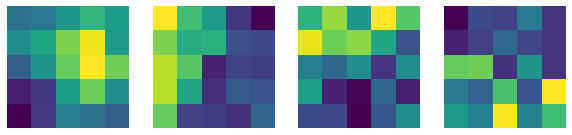

In [10]:
#提取第一层卷积层的卷积核
plt.figure(figsize = (10, 7))
print(net.conv1.weight.data.numpy().shape)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...])

#### 滤波器的演化

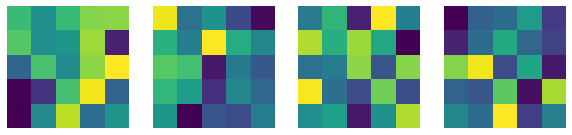

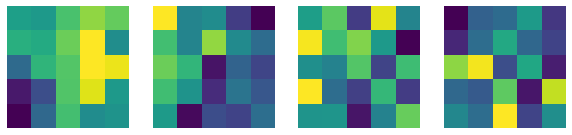

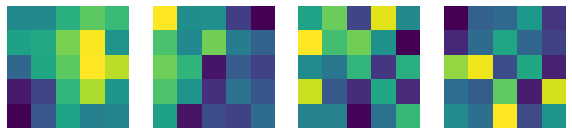

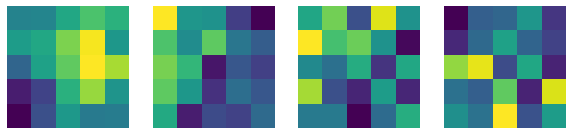

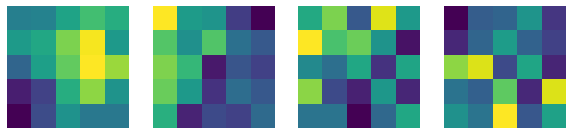

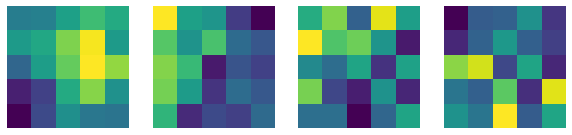

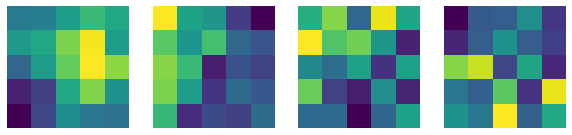

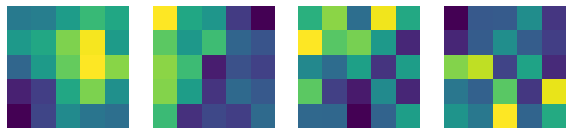

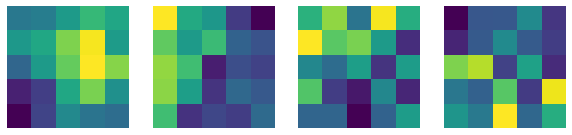

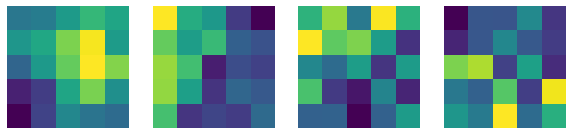

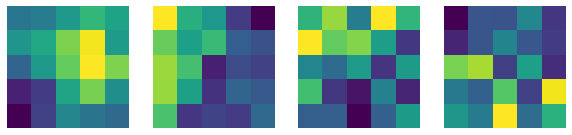

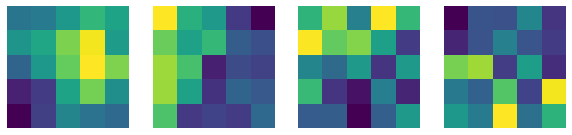

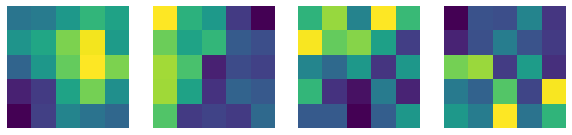

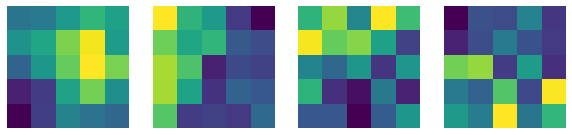

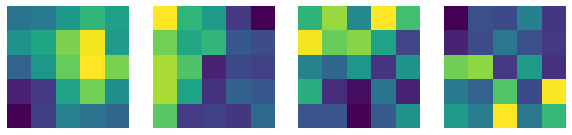

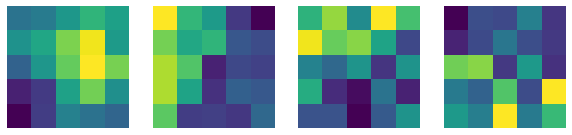

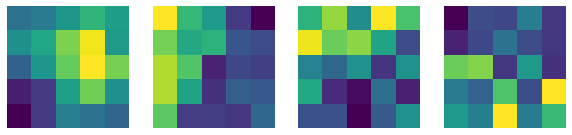

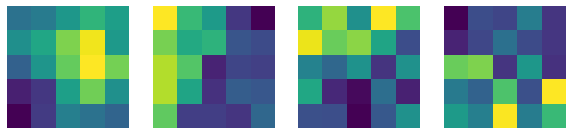

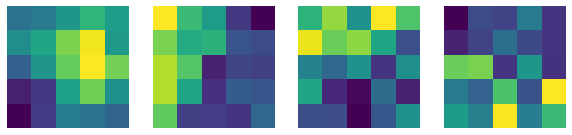

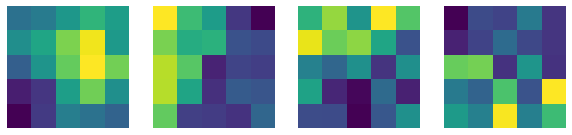

In [11]:
# 将记录在容器中的卷积核权重历史演化数据打印出来，每个epoch一次
i = 0
for tup in weights:
    if i % 10 == 0:
        layer1 = tup[0] # conv1.weight
        fig = plt.figure(figsize = (10, 7))
        for j in range(4):
            plt.subplot(1, 4, j+1)
            plt.axis('off')
            plt.imshow(layer1.numpy()[j, 0, ...])
    i += 1

#### 绘制第一层特征图

标签是： 9


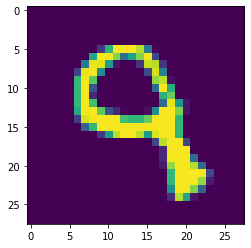

In [12]:
#随便从测试集中读入一张图片，并检验模型的分类结果，并绘制出来
idx = 4000
muteimg = test_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...])
print('标签是：',test_dataset[idx][1])

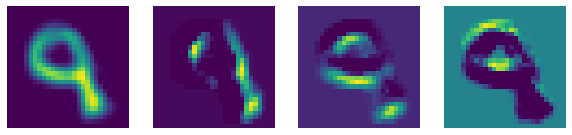

In [13]:
#调用net的retrieve_features方法可以抽取出喂入当前数据后吐出来的所有特征图（第一个卷积和第二个卷积层）

#首先定义读入的图片

#它是从test_dataset中提取第idx个批次的第0个图，其次unsqueeze的作用是在最前面添加一维，
#目的是为了让这个input_x的tensor是四维的，这样才能输入给net。补充的那一维表示batch。
input_x = test_dataset[idx][0].unsqueeze(0) 
feature_maps = net.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图

plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i, ...].data.numpy())

### 3.2 绘制第二层卷积核与特征图

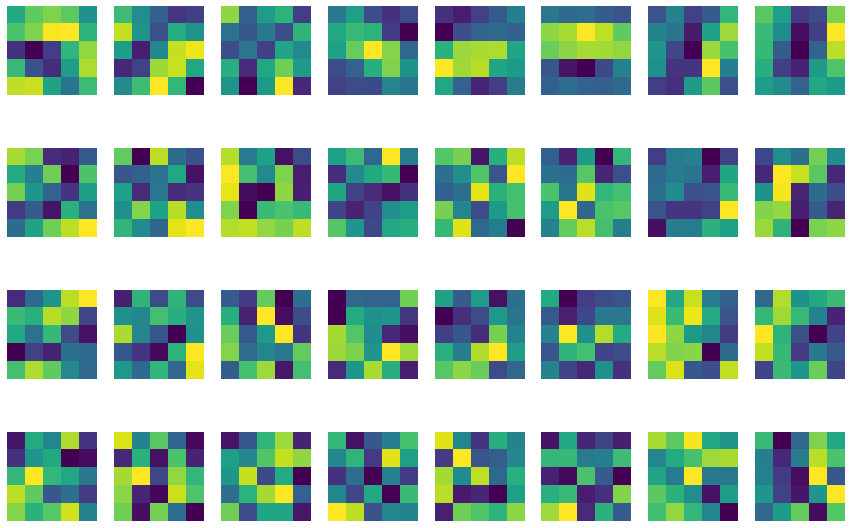

In [14]:
# 绘制第二层的卷积核，每一列对应一个卷积核，一共8个卷积核
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j, i,...])

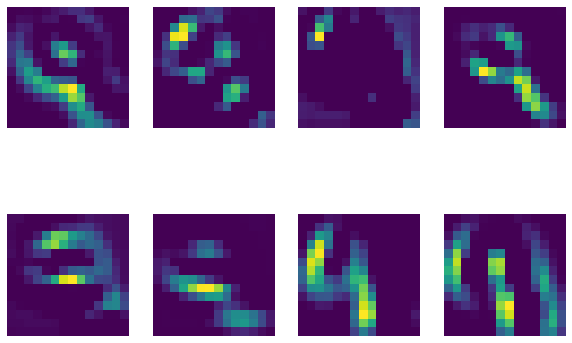

In [15]:
# 绘制第二层的特征图，一共八个
plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())

### 3.3 卷积神经网络的鲁棒性试验

该试验设计如下：我们随机挑选一张测试图像，把它往左平移w个单位，然后：
1. 考察分类结果是否变化
2. 考察两层卷积对应的featuremap们有何变化### 3.3 卷积神经网络的鲁棒性试验

该试验设计如下：我们随机挑选一张测试图像，把它往左平移w个单位，然后：
1. 考察分类结果是否变化
2. 考察两层卷积对应的featuremap们有何变化

tensor([9])


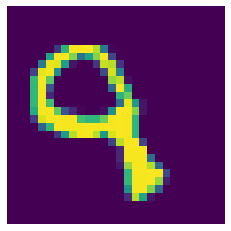

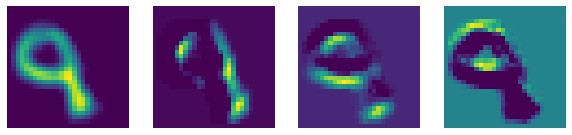

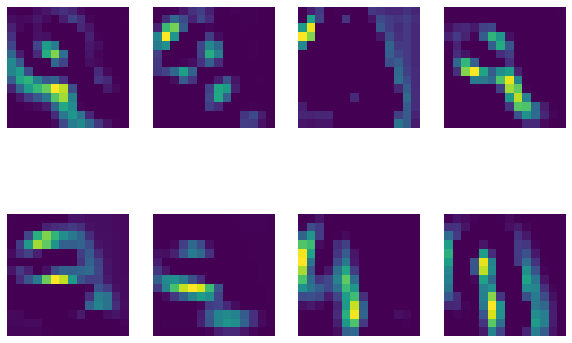

In [39]:
# 提取中test_dataset中的第idx个批次的第0个数据(1是标签)的第0个通道对应的图像，定义为a。
a = test_dataset[idx][0][0]

# 平移后的新图像将放到b中。根据a给b赋值。
b = torch.zeros(a.size()) #全0的28*28的矩阵
w = 3 #平移的长度为3个像素

# 对于b中的任意像素i,j，它等于a中的i,j+w这个位置的像素
for i in range(a.size()[0]):
    for j in range(a.size()[1] - w):
        b[i][j] = a[i][j + w]
        
# 将b画出来
muteimg = b.numpy()
plt.axis('off')
plt.imshow(muteimg)

# 把b喂给神经网络，得到分类结果pred（prediction是预测的每一个类别的概率的对数值），并把结果打印出
prediction = net(b.unsqueeze(0).unsqueeze(0))
pred  = torch.max(prediction, 1)[1]
print(pred)

#提取b对应的featuremap结果
feature_maps = net.retrieve_features(b.unsqueeze(0).unsqueeze(0))

plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i, ...].data.numpy())
    
plt.figure(figsize = (10, 7))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())